# Read and pre-process data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image

In [7]:
# Load the artists metadata
artists_path = '/kaggle/input/best-artworks-of-all-time/artists.csv'
artists_df = pd.read_csv(artists_path)

# Get the top 11 artists with more than 200 paintings
top_artists = artists_df[['name', 'paintings']].sort_values(by='paintings', ascending=False).head(11)
print("Top 11 Artists:")
print(top_artists)

Top 11 Artists:
                     name  paintings
8        Vincent van Gogh        877
30            Edgar Degas        702
13          Pablo Picasso        439
15  Pierre-Auguste Renoir        336
19         Albrecht Dürer        328
46           Paul Gauguin        311
16         Francisco Goya        291
31              Rembrandt        262
20          Alfred Sisley        259
32                 Titian        255
22           Marc Chagall        239


In [4]:
updated_name = "Albrecht_Dürer".replace("_", " ")
top_artists.iloc[4, 0] = updated_name

# Extract names of top artists
top_artist_names = top_artists['name'].tolist()
print(top_artist_names)

['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Dürer', 'Paul Gauguin', 'Francisco Goya', 'Rembrandt', 'Alfred Sisley', 'Titian', 'Marc Chagall']


In [5]:
images_dir = '/kaggle/input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
top_artist_names = top_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in top_artist_names:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Rembrandt
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Titian
Found --> /kaggle/input/best-artworks-of-all-time/images/images/Marc_Chagall


### Plot random images for visualization

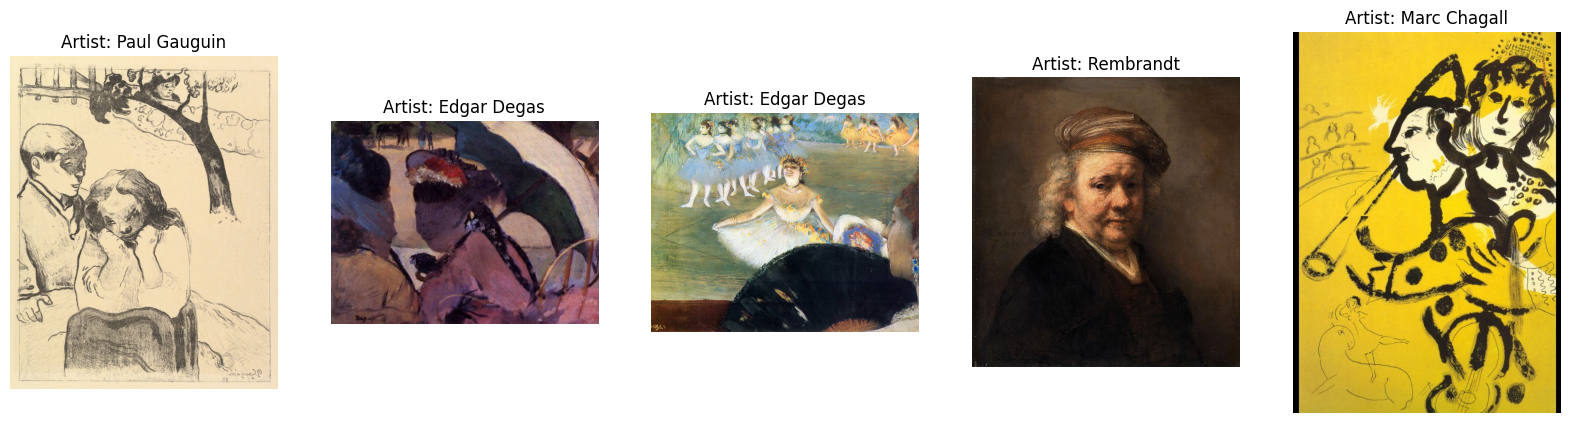

In [6]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(top_artist_names)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

# Data Augmentation

In [7]:
# Data augmentation and normalization for training and validation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Data generator for training
train_generator = data_gen.flow_from_directory(
    images_dir,
    target_size=(224, 224),
    batch_size=32,  # Batch size
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=top_artist_names.tolist()
)

# Data generator for validation
validation_generator = data_gen.flow_from_directory(
    images_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    classes=top_artist_names.tolist()
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)


Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 107 and 26


# Baseline Model


Training with learning rate: 0.001


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734320039.098567     131 service.cc:145] XLA service 0x7e49cc003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734320039.098629     131 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734320039.098634     131 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/108 ━━━━━━━━━━━━━━━━━━━━ 26:24 15s/step - accuracy: 0.0625 - loss: 2.4303

I0000 00:00:1734320046.411143     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 950ms/step - accuracy: 0.2315 - loss: 2.5090 - val_accuracy: 0.3719 - val_loss: 1.9102
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 71s 620ms/step - accuracy: 0.3953 - loss: 1.7562 - val_accuracy: 0.4211 - val_loss: 1.6602
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 613ms/step - accuracy: 0.4477 - loss: 1.6067 - val_accuracy: 0.4620 - val_loss: 1.5409
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.4566 - loss: 1.5437 - val_accuracy: 0.4889 - val_loss: 1.4766
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 612ms/step - accuracy: 0.4860 - loss: 1.4848 - val_accuracy: 0.4526 - val_loss: 1.5150
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 615ms/step - accuracy: 0.4675 - loss: 1.5126 - val_accuracy: 0.5368 - val_loss: 1.3830
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 612ms/step - accuracy: 0.5014 - loss: 1.4149 - val_accuracy: 0.5216 - val_loss: 1.3980
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 69s 611ms/step - accuracy: 0.5199 - loss: 1.4097 - va

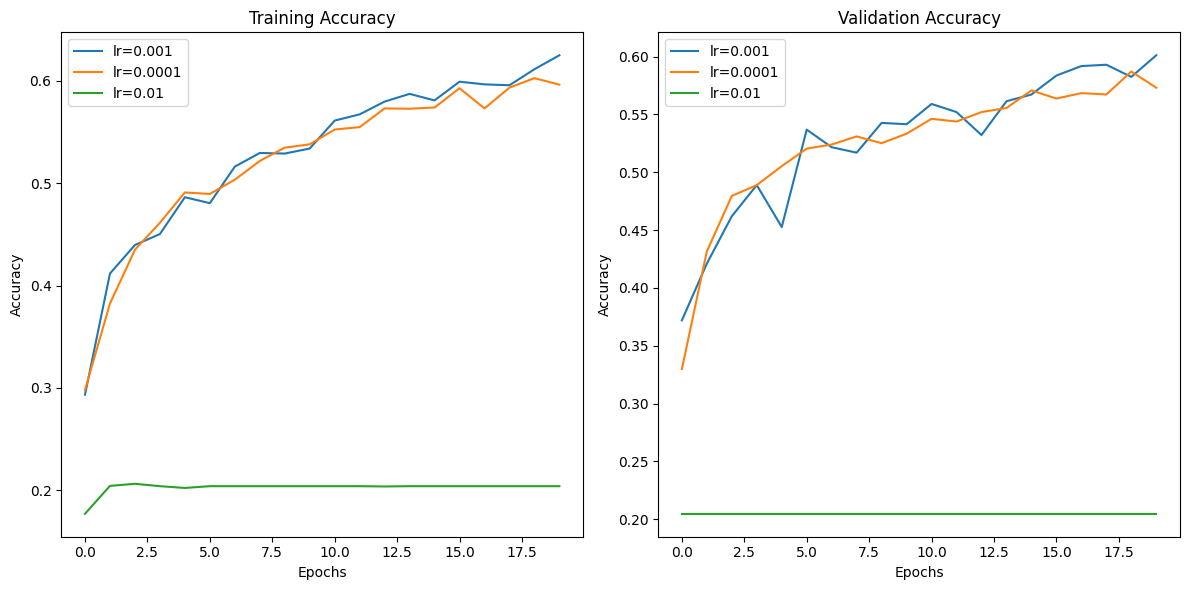

In [11]:
learning_rates = [0.001, 0.0001, 0.01]
histories = {}
models = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    # Create a new model instance for each learning rate
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(11, activation='softmax')
    ])

    # Compile the model with the current learning rate
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator
    )

    # Save the model and its history
    model_filename = f"model_lr_{lr}.h5"
    model.save(model_filename)
    models[lr] = model

    # Store the history for later analysis
    histories[lr] = history.history

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
for lr, hist in histories.items():
    plt.plot(hist['accuracy'], label=f"lr={lr}")
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
for lr, hist in histories.items():
    plt.plot(hist['val_accuracy'], label=f"lr={lr}")
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate model on test dataset

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.6064 - loss: 1.1991
Test Loss: 1.214993953704834
Test Accuracy: 0.6035087704658508
Found 855 images belonging to 11 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 508ms/step
Classification Report:
                        precision    recall  f1-score   support

     Vincent_van_Gogh       0.56      0.65      0.60       175
          Edgar_Degas       0.65      0.63      0.64       140
        Pablo_Picasso       0.55      0.54      0.54        87
Pierre-Auguste_Renoir       0.57      0.37      0.45        67
      Albrecht_Dürer       0.80      0.86      0.83        65
         Paul_Gauguin       0.62      0.53      0.57        62
       Francisco_Goya       0.48      0.59      0.53        58
            Rembrandt       0.59      0.69      0.64        52
        Alfred_Sisley       0.69      0.53      0.60        51
               Titian       0.41      0.47      0.44        51
         Marc_Chagall       0.83      0.62      0.71        47

             accuracy                           0.60       855
            macro avg       0.61      0.59      0.60       855
         weighted avg       0.61      0.60      0.

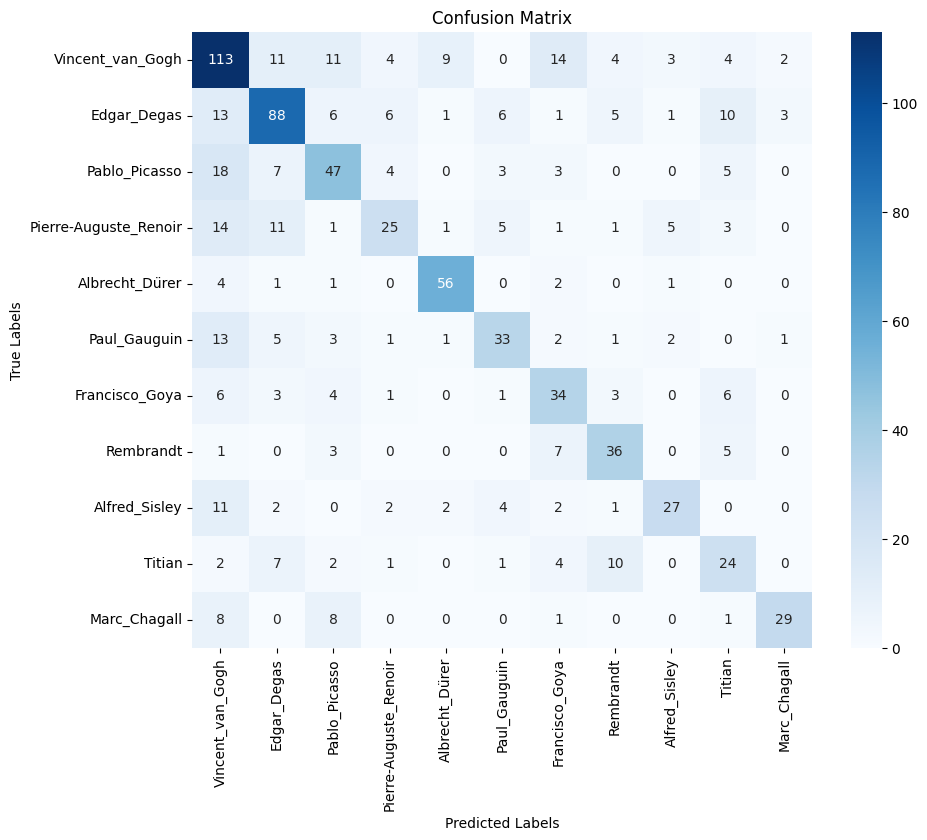

In [30]:
# Evaluate the model
best_lr = 0.001
loaded_model = load_model(f"model_lr_{best_lr}.h5")

loss, accuracy = loaded_model.evaluate(validation_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Generate predictions for the test data
test_generator = data_gen.flow_from_directory(images_dir,
                                  target_size=(224, 224),
                                  shuffle = False,
                                  batch_size=32,
                                  class_mode='categorical',
                                  subset='validation',
                                  classes=top_artist_names.tolist(),                    
                                  seed=None
)

predictions = loaded_model.predict(test_generator)
y_pred = predictions.argmax(axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

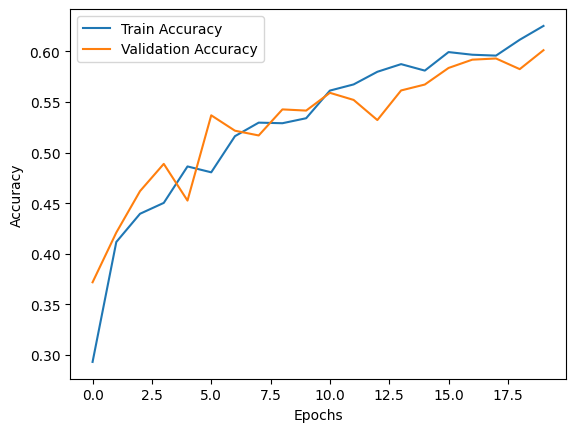

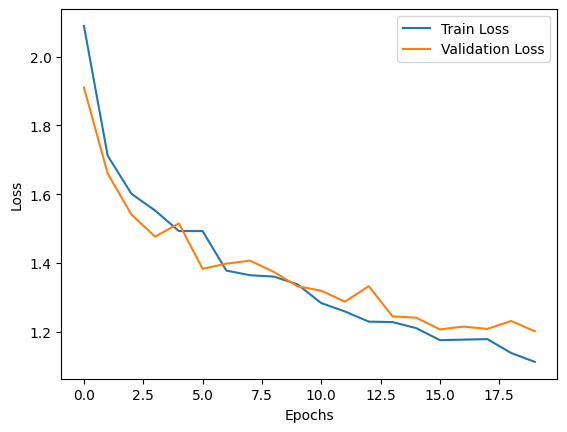

In [31]:
# Plot accuracy
plt.plot(histories[best_lr]['accuracy'], label='Train Accuracy')
plt.plot(histories[best_lr]['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(histories[best_lr]['loss'], label='Train Loss')
plt.plot(histories[best_lr]['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Verify if the model accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual Artist: Paul Gauguin
Predicted Artist: Vincent van Gogh
Confidence: 41.18%


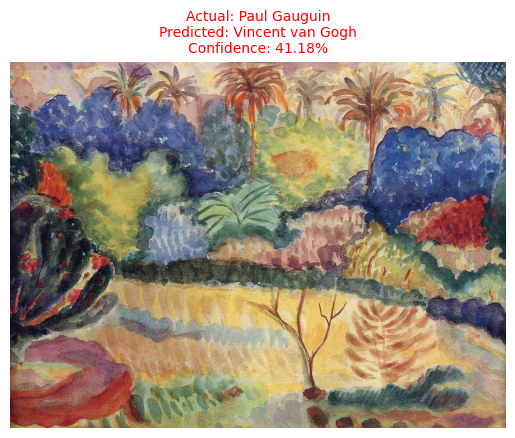

In [35]:
def identify_artist_from_random_image(model, validation_generator):
    """
    Identifies the artist of a random image from the test dataset.

    Parameters:
        model (keras.Model): Trained model for predictions.
        test_generator (ImageDataGenerator): Test data generator.
    """
    # Get the test directory from the generator
    validation_images_dir = validation_generator.directory

    # Choose a random class (artist)
    random_artist = random.choice(list(validation_generator.class_indices.keys()))

    # Choose a random image from the selected artist's folder
    random_image_file = random.choice(
        os.listdir(os.path.join(validation_images_dir, random_artist))
    )
    image_path = os.path.join(validation_images_dir, random_artist, random_image_file)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = loaded_model.predict(img_array)
    predicted_idx = np.argmax(prediction)
    prediction_probability = np.max(prediction)

    # Map indices to class labels
    labels = {v: k for k, v in validation_generator.class_indices.items()}
    predicted_artist = labels[predicted_idx].replace("_", " ")
    actual_artist = random_artist.replace("_", " ")

    # Display the result
    print(f"Actual Artist: {actual_artist}")
    print(f"Predicted Artist: {predicted_artist}")
    print(f"Confidence: {prediction_probability:.2%}")

    # Plot the image
    plt.imshow(plt.imread(image_path))
    plt.title(
        f"Actual: {actual_artist}\nPredicted: {predicted_artist}\nConfidence: {prediction_probability:.2%}",
        color="green" if predicted_artist == actual_artist else "red",
        fontsize=10,
    )
    plt.axis("off")
    plt.show()

# Usage example
identify_artist_from_random_image(model, validation_generator)

# Simplified ResNet-18 Model from scratch

In [55]:
resnet_model = Sequential([
    Conv2D(64, (7, 7), strides=2, padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=2, padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), strides=2, padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), strides=2, padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Save the trained model
resnet_model.save('artist_style_classifier.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 77s 636ms/step - accuracy: 0.1801 - loss: 2.3303 - val_accuracy: 0.2047 - val_loss: 2.2324
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 71s 620ms/step - accuracy: 0.2349 - loss: 2.1673 - val_accuracy: 0.2596 - val_loss: 2.0636
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 616ms/step - accuracy: 0.2812 - loss: 2.0514 - val_accuracy: 0.2713 - val_loss: 2.0338
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 612ms/step - accuracy: 0.2857 - loss: 2.0046 - val_accuracy: 0.2725 - val_loss: 2.0231
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 71s 624ms/step - accuracy: 0.3000 - loss: 1.9284 - val_accuracy: 0.3439 - val_loss: 1.8603
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.3470 - loss: 1.8282 - val_accuracy: 0.3228 - val_loss: 1.8564
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 71s 619ms/step - accuracy: 0.3935 - loss: 1.7266 - val_accuracy: 0.4117 - val_loss: 1.7136
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 616ms/step - accuracy: 0.4005 - loss: 1

## Evaluate model on test dataset

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 504ms/step - accuracy: 0.4632 - loss: 1.4653
Test Loss: 1.4843374490737915
Test Accuracy: 0.4748538136482239
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 506ms/step
Classification Report:
                        precision    recall  f1-score   support

     Vincent_van_Gogh       0.51      0.50      0.51       175
          Edgar_Degas       0.39      0.71      0.51       140
        Pablo_Picasso       0.62      0.26      0.37        87
Pierre-Auguste_Renoir       0.33      0.03      0.05        67
      Albrecht_Dürer       0.71      0.92      0.81        65
         Paul_Gauguin       0.39      0.45      0.42        62
       Francisco_Goya       0.54      0.24      0.33        58
            Rembrandt       0.46      0.73      0.57        52
        Alfred_Sisley       0.51      0.75      0.60        51
               Titian       0.44      0.16      0.23        51
         Marc_Chagall       0.67      0.47      0.55        47

             accuracy               

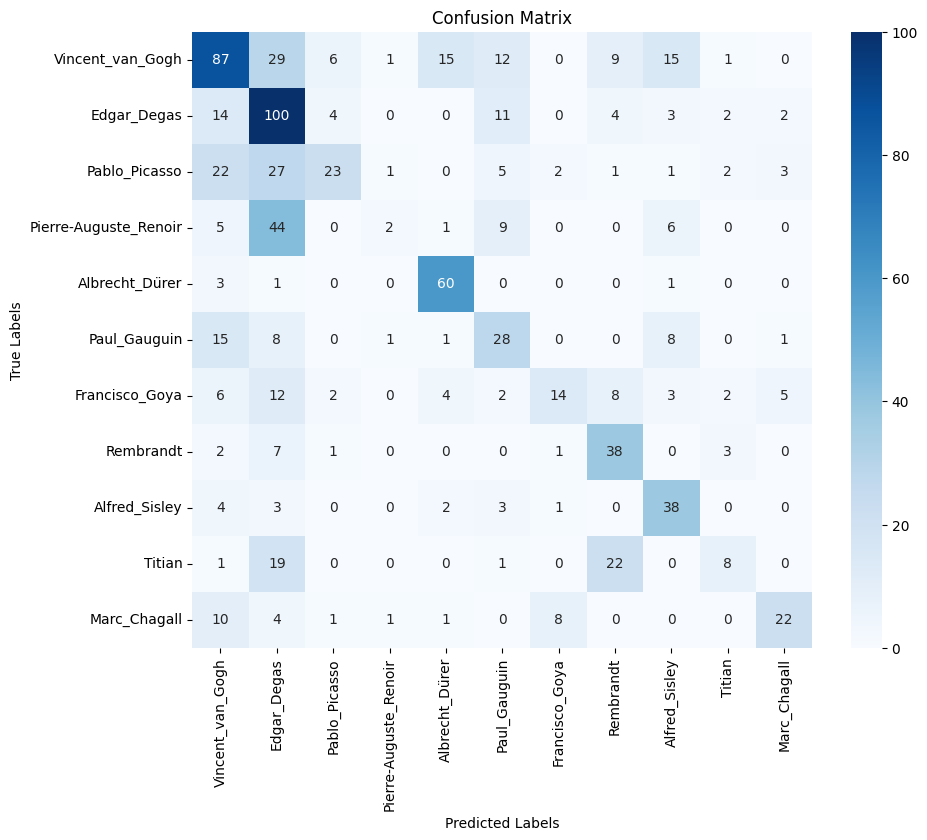

In [56]:
loss, accuracy = resnet_model.evaluate(validation_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Generate predictions for the test data
predictions = resnet_model.predict(test_generator)
y_pred = predictions.argmax(axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

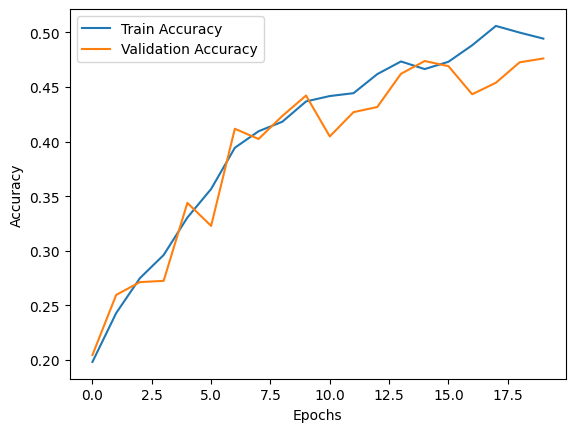

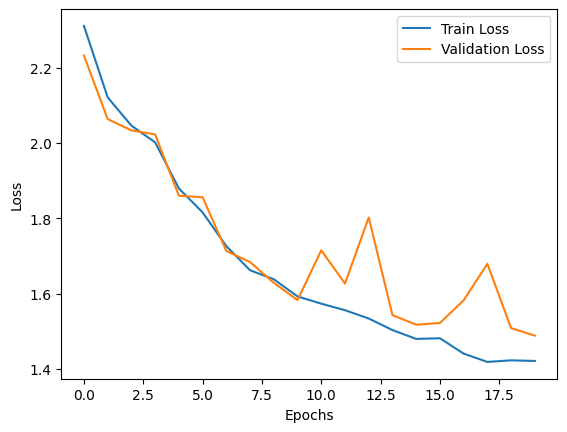

In [57]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()